# Adaptive CMA-ES configurations - Analysis

This Python Notebook covers the analysis of pre-processed data for the adaptive CMA-ES research.

The input data consists of CSVs with the required runtimes for each pre-specified target for all runs, separated into files for each function/dimensionality pair. For details on the pre-processing that went into creating this data, please refer to the `pre-processing.ipynb/html` notebook.

An example with target values 100, 1 and 0.01:

`idx |   1   2   3 ...   56   57   58   59 ...    164    165    166    167`<br>
`val | 124 102  94 ... 1.13 1.06 0.98 0.96 ... 0.0123 0.0109 0.0098 0.0097`

For section `$\inf$-100`, the first index where the value is _below_ 100 is 3. For the next target the index is 58, and for the final target the first index is 166.


> Sander van Rijn<br>
> s.j.van.rijn@liacs.leidenuniv.nl<br>
> LIACS<br>
> 2018-03-29

## Initialization

In [38]:
%matplotlib inline

from __future__ import division, print_function

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from collections import Counter, defaultdict
from matplotlib import rc
rc('text', usetex=True)

In [2]:
# Some utility functions for dealing with the representations

# First, some hardcoded variables
num_options_per_module = [2]*9        # Binary part
num_options_per_module.extend([3]*2)  # Ternary part
max_length = 11
factors = [2304, 1152, 576, 288, 144, 72, 36, 18, 9, 3, 1]

def list_all_representations():
    """ Create a list of all possible representations for the modular CMA-ES.
        Each representation is itself a list with <max_length> integer entries {0, 1, ..., n},
        where 'n' is the number of options for the module in that position.
    """
    products = []
    # count how often there is a choice of x options
    counts = Counter(num_options_per_module)
    for num, count in sorted(counts.items(), key=lambda x: x[0]):
        products.append(product(range(num), repeat=count))
    all_representations = []
    for representation in list(product(*products)):
        all_representations.append(list(sum(representation, ())))
    return all_representations


def reprToString(representation):
    """ Function that converts the structure parameters of a given ES-structure representation to a string

        >>> reprToInt([0,0,0,0,0,1,0,1,0,1,0])
        >>> '00000101010'
    """
    return ''.join([str(i) for i in representation[:max_length]])

In [3]:
data_location = '/media/rijnsjvan/Data/SurfDrive/Research Data/Adaptive ES/anytime_convergence/data/'
# file_name = 'steepness_data_{ndim}D-f{fid}.csv'
# file_name = 'interpolated_ART_data_{ndim}D-f{fid}.csv'
# file_name = 'stepwise_ERT_data_{ndim}D-f{fid}.csv'
file_name = 'ERT_data_{ndim}D-f{fid}.csv'


#TODO: Retrieve this information from the files instead?
ndims = [5, 20]
fids = [1, 10, 15, 20]

num_steps = 51
powers = np.round(np.linspace(2, -8, num_steps), decimals=1)
target_values = np.power([10]*num_steps, powers)

columns = ['10e{}'.format(power) for power in powers]


np.set_printoptions(linewidth=1000, edgeitems=30)
pd.set_option('display.max_columns', 60)
pd.set_option('display.width', 2000)

# Exploration
Using the data in (one of) the CSV files, we'll start with some exploratory analysis.
Any useful procedures will be coded as functions, making them easy to re-use for a final full analysis later on.

In [4]:
def get_data(ndim, fid):
    return pd.read_csv(data_location + file_name.format(ndim=ndim, fid=fid), index_col=0)

# Starting with 5D F1 as an example
df = get_data(ndim=5, fid=1)
df.head()

,Representation,ndim,function ID,10e2.0,10e1.8,10e1.6,10e1.4,10e1.2,10e1.0,10e0.8,10e0.6,10e0.4,10e0.2,10e0.0,10e-0.2,10e-0.4,10e-0.6,10e-0.8,10e-1.0,10e-1.2,10e-1.4,10e-1.6,10e-1.8,10e-2.0,10e-2.2,10e-2.4,10e-2.6,10e-2.8,10e-3.0,10e-3.2,10e-3.4,10e-3.6,10e-3.8,10e-4.0,10e-4.2,10e-4.4,10e-4.6,10e-4.8,10e-5.0,10e-5.2,10e-5.4,10e-5.6,10e-5.8,10e-6.0,10e-6.2,10e-6.4,10e-6.6,10e-6.8,10e-7.0,10e-7.2,10e-7.4,10e-7.6,10e-7.8,10e-8.0
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",5,1,0.65,2.50,5.65,11.60,22.95,73.65,139.25,221.55,302.70,346.00,365.80,372.85,390.20,412.85,429.60,433.60,446.10,467.15,481.90,503.05,526.35,536.70,555.50,567.45,580.05,599.45,613.50,630.80,646.00,662.30,677.90,694.00,700.8,716.40,735.05,749.35,776.70,789.05,807.50,819.55,832.90,856.50,873.40,884.55,907.25,918.2,932.45,942.85,962.70,971.95,988.15
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",5,1,1.35,4.95,9.75,17.45,41.45,84.80,129.05,248.05,278.35,326.70,339.90,352.35,367.15,371.95,394.15,414.30,432.65,443.95,466.50,477.25,497.35,509.45,519.90,544.80,556.35,574.10,583.05,602.35,619.10,640.20,650.90,659.65,677.7,701.20,718.70,726.30,739.85,755.15,777.60,791.75,809.25,825.15,836.00,856.45,869.20,888.7,908.90,919.00,936.80,950.05,958.25
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]",5,1,0.50,2.75,5.55,13.45,38.05,82.80,148.20,248.20,267.30,282.05,333.25,350.80,362.65,383.35,394.30,419.35,438.70,453.75,466.00,481.05,490.25,504.55,525.05,543.20,556.05,566.95,581.15,600.10,609.30,632.20,642.45,657.25,674.3,698.00,715.45,728.25,740.15,759.25,771.40,780.70,789.70,815.20,836.90,854.20,868.20,887.9,901.05,907.10,929.60,940.80,958.45
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",5,1,0.25,4.00,7.95,15.20,31.05,78.05,141.20,248.15,271.65,285.70,299.55,309.00,336.30,343.05,353.70,368.05,384.15,399.85,412.70,428.40,437.55,451.35,464.50,473.90,487.05,497.10,507.25,525.35,537.25,546.30,563.10,575.60,588.7,604.80,627.00,632.35,646.00,656.25,666.85,674.05,698.40,708.90,717.00,730.95,745.05,759.2,774.75,792.35,803.50,819.85,832.20
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]",5,1,0.30,2.95,7.30,14.50,30.20,94.15,204.95,268.25,293.10,302.90,320.15,337.80,351.10,368.90,381.05,394.70,408.70,420.20,429.65,438.00,448.35,467.55,482.20,502.20,516.90,531.20,545.60,550.80,563.40,577.95,590.65,605.80,619.5,630.15,643.20,662.95,674.60,682.55,697.00,712.15,728.60,740.55,747.55,761.70,769.70,787.5,801.85,815.50,830.25,848.50,857.60


In [5]:
def absolutetodifferences(df):
    return_df = df.copy()
    df_columns = list(reversed(columns))
    for column_a, column_b in zip(columns, columns[1:]):
        return_df[column_b] = df[column_b] - df[column_a]
    return return_df

# Next, we get the differences between the running times for each of the targets
df_diff = absolutetodifferences(df)
df_diff.head()

,Representation,ndim,function ID,10e2.0,10e1.8,10e1.6,10e1.4,10e1.2,10e1.0,10e0.8,10e0.6,10e0.4,10e0.2,10e0.0,10e-0.2,10e-0.4,10e-0.6,10e-0.8,10e-1.0,10e-1.2,10e-1.4,10e-1.6,10e-1.8,10e-2.0,10e-2.2,10e-2.4,10e-2.6,10e-2.8,10e-3.0,10e-3.2,10e-3.4,10e-3.6,10e-3.8,10e-4.0,10e-4.2,10e-4.4,10e-4.6,10e-4.8,10e-5.0,10e-5.2,10e-5.4,10e-5.6,10e-5.8,10e-6.0,10e-6.2,10e-6.4,10e-6.6,10e-6.8,10e-7.0,10e-7.2,10e-7.4,10e-7.6,10e-7.8,10e-8.0
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",5,1,0.65,1.85,3.15,5.95,11.35,50.70,65.60,82.30,81.15,43.30,19.80,7.05,17.35,22.65,16.75,4.00,12.50,21.05,14.75,21.15,23.30,10.35,18.80,11.95,12.60,19.40,14.05,17.30,15.20,16.30,15.60,16.10,6.80,15.60,18.65,14.30,27.35,12.35,18.45,12.05,13.35,23.60,16.90,11.15,22.70,10.95,14.25,10.40,19.85,9.25,16.20
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",5,1,1.35,3.60,4.80,7.70,24.00,43.35,44.25,119.00,30.30,48.35,13.20,12.45,14.80,4.80,22.20,20.15,18.35,11.30,22.55,10.75,20.10,12.10,10.45,24.90,11.55,17.75,8.95,19.30,16.75,21.10,10.70,8.75,18.05,23.50,17.50,7.60,13.55,15.30,22.45,14.15,17.50,15.90,10.85,20.45,12.75,19.50,20.20,10.10,17.80,13.25,8.20
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]",5,1,0.50,2.25,2.80,7.90,24.60,44.75,65.40,100.00,19.10,14.75,51.20,17.55,11.85,20.70,10.95,25.05,19.35,15.05,12.25,15.05,9.20,14.30,20.50,18.15,12.85,10.90,14.20,18.95,9.20,22.90,10.25,14.80,17.05,23.70,17.45,12.80,11.90,19.10,12.15,9.30,9.00,25.50,21.70,17.30,14.00,19.70,13.15,6.05,22.50,11.20,17.65
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",5,1,0.25,3.75,3.95,7.25,15.85,47.00,63.15,106.95,23.50,14.05,13.85,9.45,27.30,6.75,10.65,14.35,16.10,15.70,12.85,15.70,9.15,13.80,13.15,9.40,13.15,10.05,10.15,18.10,11.90,9.05,16.80,12.50,13.10,16.10,22.20,5.35,13.65,10.25,10.60,7.20,24.35,10.50,8.10,13.95,14.10,14.15,15.55,17.60,11.15,16.35,12.35
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]",5,1,0.30,2.65,4.35,7.20,15.70,63.95,110.80,63.30,24.85,9.80,17.25,17.65,13.30,17.80,12.15,13.65,14.00,11.50,9.45,8.35,10.35,19.20,14.65,20.00,14.70,14.30,14.40,5.20,12.60,14.55,12.70,15.15,13.70,10.65,13.05,19.75,11.65,7.95,14.45,15.15,16.45,11.95,7.00,14.15,8.00,17.80,14.35,13.65,14.75,18.25,9.10


We can already see a problem here: Some of the smallest values are zeroes.
This means that the actual improvement step made by the algorithm went across the specified targets.

In [6]:
print(df_diff[columns].min(axis=0))

10e2.0     0.00
10e1.8     0.15
10e1.6     0.40
10e1.4     1.10
10e1.2     1.80
10e1.0     1.90
10e0.8     2.55
10e0.6     3.10
10e0.4     2.80
10e0.2     2.85
10e0.0     2.00
10e-0.2    3.45
10e-0.4    1.70
10e-0.6    1.55
10e-0.8    3.75
10e-1.0    0.00
10e-1.2    0.00
10e-1.4    0.00
10e-1.6    0.00
10e-1.8    0.00
10e-2.0    0.00
10e-2.2    0.00
10e-2.4    0.00
10e-2.6    0.00
10e-2.8    0.00
10e-3.0    0.00
10e-3.2    0.00
10e-3.4    0.00
10e-3.6    0.00
10e-3.8    0.00
10e-4.0    0.00
10e-4.2    0.00
10e-4.4    0.00
10e-4.6    0.00
10e-4.8    0.00
10e-5.0    0.00
10e-5.2    0.00
10e-5.4    0.00
10e-5.6    0.00
10e-5.8    0.00
10e-6.0    0.00
10e-6.2    0.00
10e-6.4    0.00
10e-6.6    0.00
10e-6.8    0.00
10e-7.0    0.00
10e-7.2    0.00
10e-7.4    0.00
10e-7.6    0.00
10e-7.8    0.00
10e-8.0    0.00
dtype: float64


In [7]:
def aggregateByMean(df):
    df_means = df.groupby(by=['Representation', 'ndim', 'function ID']).mean(numeric_only=True)
    df_means = df_means.drop(columns=['instance ID', 'repetition'])
    df_means = df_means.reset_index()
    return df_means

def aggregateByStd(df):
    df_std = df.groupby(by=['Representation', 'ndim', 'function ID']).std()
    df_std = df_std.drop(columns=['instance ID', 'repetition'])
    df_std = df_std.reset_index()
    return df_std

def aggregateByMax(df):
    df_means = df.groupby(by=['Representation', 'ndim', 'function ID']).max(axis=1)
    df_means = df_means.drop(columns=['instance ID', 'repetition'])
    df_means = df_means.reset_index()
    return df_means

def aggregateByMedian(df):
    df_means = df.groupby(by=['Representation', 'ndim', 'function ID']).median(numeric_only=True)
    df_means = df_means.drop(columns=['instance ID', 'repetition'])
    df_means = df_means.reset_index()
    return df_means

def aggregateBy(df, aggregation):
    if aggregation == 'mean':
        return aggregateByMean(df)
    elif aggregation == 'std':
        return aggregateByStd(df)
    elif aggregation == 'max':
        return aggregateByMax(df)
    elif aggregation == 'median':
        return aggregateByMedian(df)
    else:
        raise ValueError("Invalid choice for 'aggregation': {aggregation}")

In [8]:
# # Then we can aggregate
# df_diff = aggregateByMax(absolutetodifferences(df))
# df_diff.head()

If we aggregate before calculating the differences, we can end up disrupting the monotonically decreasing nature of our data. This would result in a negative difference score!

Instead, by first calculating the differences, we can then aggregate over the actually existing differences

In [9]:
section_labels = ['\inf - 10e{}'.format(powers[0])]
section_labels.extend(['10e{} - 10e{}'.format(a, b) for a, b in zip(powers[:-1], powers[1:])])

def plotOnAxis(df, columns, ax, *, title=None, legend=True):
    for idx, row in df.iterrows():
        ax.plot(row[columns].values, '-', label=row['Representation'])

    ax.set_ylabel("\'steepness\'")
    ax.set_xlabel('convergence sections')
    ax.set_xticks(np.arange(len(target_values)))
    ax.set_xticklabels(section_labels)
    ax.xaxis.set_tick_params(rotation=90)
    if title:
        ax.set_title(title)
    if legend:
        ax.legend(loc=0)

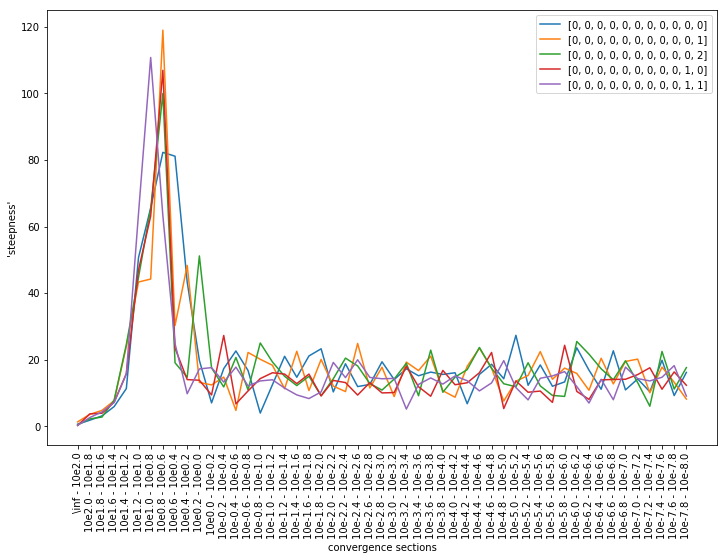

In [10]:
# Let's plot the head (=first 5 rows) of the currently loaded data as an example
fig, ax = plt.subplots(figsize=(12,8))
plotOnAxis(df_diff.head(), columns, ax)
plt.show()

In [11]:
# Extracting only the configurations that are best between a pair of targets rather than all 4,608...
def selectSmallestPerColumn(df, columns, nsmallest=1):
    indices = set()
    for col in columns:
        if df[col].max() > 0:
            new_indices = set(df[col].nsmallest(nsmallest).axes[0])
            indices = indices.union(new_indices)
    return df.iloc[sorted(indices)]

selectSmallestPerColumn(df_diff, columns).head()

,Representation,ndim,function ID,10e2.0,10e1.8,10e1.6,10e1.4,10e1.2,10e1.0,10e0.8,10e0.6,10e0.4,10e0.2,10e0.0,10e-0.2,10e-0.4,10e-0.6,10e-0.8,10e-1.0,10e-1.2,10e-1.4,10e-1.6,10e-1.8,10e-2.0,10e-2.2,10e-2.4,10e-2.6,10e-2.8,10e-3.0,10e-3.2,10e-3.4,10e-3.6,10e-3.8,10e-4.0,10e-4.2,10e-4.4,10e-4.6,10e-4.8,10e-5.0,10e-5.2,10e-5.4,10e-5.6,10e-5.8,10e-6.0,10e-6.2,10e-6.4,10e-6.6,10e-6.8,10e-7.0,10e-7.2,10e-7.4,10e-7.6,10e-7.8,10e-8.0
34,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1]",5,1,0.0,3.60,3.3,6.85,14.55,41.25,49.70,78.65,36.05,51.45,18.950000,19.500000,15.200000,7.600000,20.200000,1.495000e+01,12.65,1.770000e+01,11.65,13.4,1.505000e+01,13.250000,14.250000,9.800000e+00,23.0,14.05,9.75,19.35,10.9,26.30,8.70,14.30,15.5,17.250000,5.85,10.700000,26.150000,18.25,11.0,17.55,9.7,18.55,10.5,17.95,12.7,8.25,20.3,15.3,15.55,19.25,16.35
85,"[0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1]",5,1,0.3,1.65,2.5,4.75,18.00,39.25,90.25,282.65,1560.75,5080.40,6835.300000,139422.825000,150293.298077,236723.276923,117315.355556,8.872220e+05,499381.65,1.055250e+03,39.50,831959.0,5.133333e+01,147.333333,288.666667,1.664180e+06,54.5,141.00,128.00,228.00,128.5,17.00,137.50,71.00,162.0,52.500000,228.00,177.500000,17.500000,89.00,119.5,79.00,64.0,89.50,274.5,45.00,0.0,389.50,118.0,0.0,123.50,23.50,234.00
86,"[0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 2]",5,1,0.3,0.25,3.6,5.45,12.80,58.50,111.55,391.70,1215.75,2119.50,8410.500000,280291.638462,356254.905983,6091.555556,140009.875000,4.212366e+05,333443.70,1.333418e+06,23.00,22.0,1.666596e+06,11.000000,0.000000,2.000000e+00,21.0,5.00,4999779.00,51.00,15.0,19.00,21.00,9.00,7.0,15.000000,6.00,2.000000,0.000000,36.00,35.0,0.00,10.0,53.00,0.0,6.00,20.0,3.00,0.0,45.0,0.00,15.00,0.00
88,"[0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 1]",5,1,0.6,0.70,1.4,9.65,2.95,43.30,138.85,621.45,957.70,1751.80,66000.155556,172481.801587,128963.226190,286027.527778,891395.488889,2.999171e+06,4998284.00,1.890000e+02,0.00,504.0,1.320000e+02,99.000000,0.000000,0.000000e+00,0.0,405.00,540.00,111.00,309.0,55.00,416.00,33.00,211.0,20.000000,265.00,155.000000,0.000000,120.00,0.0,440.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,"[0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 2]",5,1,0.3,1.10,3.4,4.25,27.00,39.85,128.75,544.75,1018.30,4052.40,34796.005263,194965.466165,297931.428571,675747.500000,340279.700000,1.420000e+01,18.00,3.600000e+01,23.20,13.8,1.980000e+01,6.200000,22.200000,3.740000e+01,17.0,15.40,2.40,18.00,499964.7,12.25,0.25,26.75,4.0,833311.583333,20.00,8.333333,12.333333,2.00,1666588.0,7.00,28.0,17.50,8.5,23.50,9.5,0.00,34.5,11.0,20.50,16.00,0.50


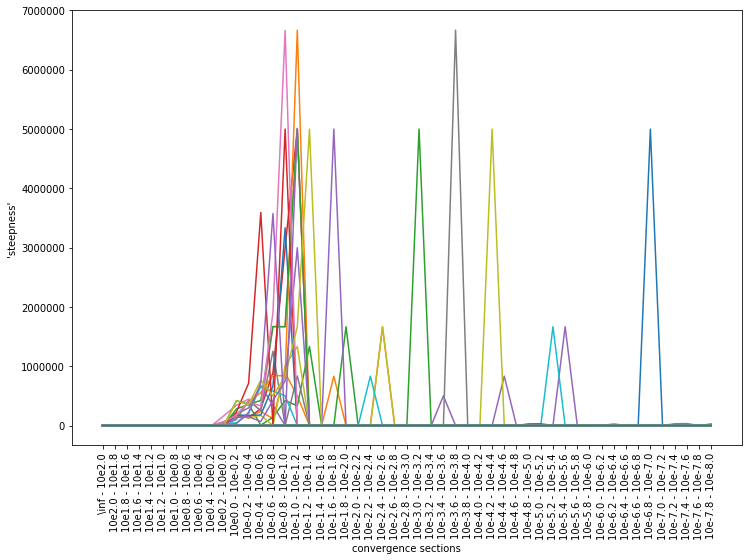

In [12]:
# Now we plot all differences for each configuration that is best between at least one pair of targets
subset = selectSmallestPerColumn(df_diff, columns)
fig, ax = plt.subplots(figsize=(12,8))
plotOnAxis(subset, columns, ax, legend=False)
plt.show()

We get some really large values here, which are actually not what we want to see: higher values mean bad performance.

Instead, at least to visualize, it's more interesting to look at the 1/$\delta$'s.

In [13]:
def makecleaninverses(df, columns):
    return_df = df.copy()
    for col in columns:
        return_df[col] = 1/df[col]
    return_df = return_df.replace(np.inf, np.NaN)
    return return_df

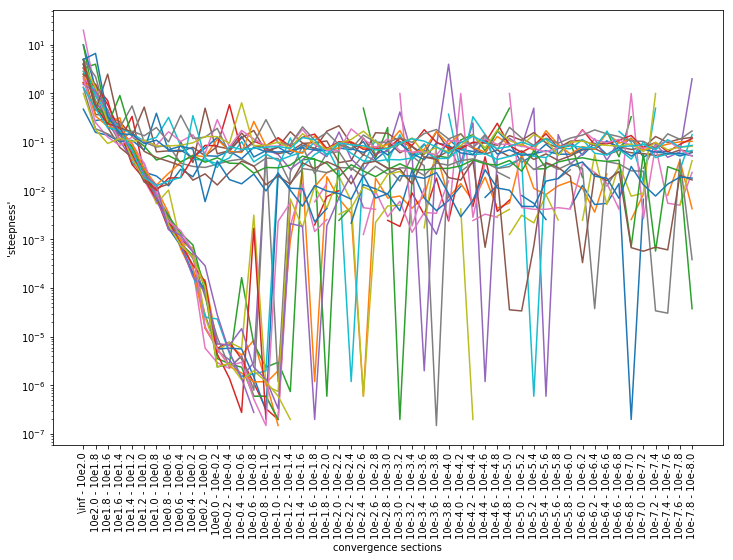

In [14]:
# Now we plot all differences for each configuration that is best between at least one pair of targets
subset = makecleaninverses(selectSmallestPerColumn(df_diff, columns), columns)
fig, ax = plt.subplots(figsize=(12,8))
plotOnAxis(subset, columns, ax, legend=False)
plt.yscale('log')
plt.show()

In [15]:
#SOME DEBUGGING INFO
# idx = df_diff[columns[14]].nsmallest(1).axes[0]
# print(idx)
# rep = df_diff.iloc[idx]['Representation'].values[0]
# print(rep)

# subset = df[df['Representation'] == rep]

# print(idx)
# print(subset.as_matrix(columns).astype(int))
# print(df_diff.iloc[idx].as_matrix(columns))

#SOME DEBUGGING INFO
# print(absolutetodifferences(aggregateByMean(subset)).as_matrix(columns).astype(int))

# Analysis of all experiments

In [16]:
# Just some caching
full_data = {(ndim, fid): get_data(ndim=ndim, fid=fid) for ndim, fid in product(ndims, fids)}

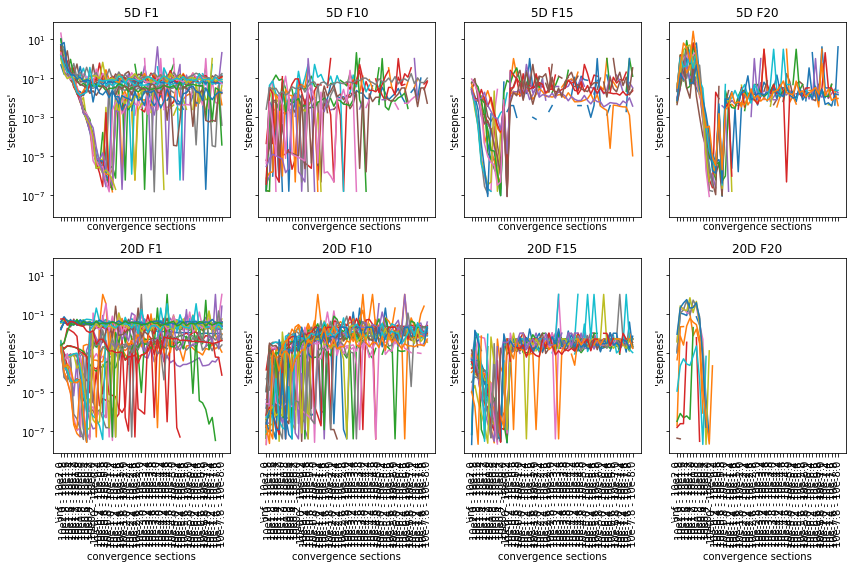

In [17]:
# Because it's defined as a simple-to-use function, we can now plot this data for all available datasets
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(12,8), sharex=True, sharey=True)

for exp, ax in zip(product(ndims, fids), axes.flatten()):
    ndim, fid = exp
#     df_means = aggregateByMean(absolutetodifferences(full_data[(ndim, fid)]))
    df_means = absolutetodifferences(full_data[(ndim, fid)])
    subset = makecleaninverses(selectSmallestPerColumn(df_means, columns), columns)
    plotOnAxis(subset, columns, ax, title='{}D F{}'.format(ndim, fid), legend=False)
    ax.set_yscale('log')

plt.tight_layout()
plt.show()

In [18]:
df_diff = absolutetodifferences(get_data(ndim=5, fid=1))
df_diff[columns] = df_diff[columns].replace(0, np.NaN)  # we replace 0 by NaN so they're automatically excluded
# df_diff = aggregateByMax(df_diff)
subset = selectSmallestPerColumn(df_diff, columns)

# And now the hypothetical result if we take the best sub-result per section...
print(subset[columns].min(axis=0))
print(subset[columns].min(axis=0).sum())

10e2.0     0.050000
10e1.8     0.150000
10e1.6     0.400000
10e1.4     1.100000
10e1.2     1.800000
10e1.0     1.900000
10e0.8     2.550000
10e0.6     3.100000
10e0.4     2.800000
10e0.2     2.850000
10e0.0     2.000000
10e-0.2    3.450000
10e-0.4    1.700000
10e-0.6    1.550000
10e-0.8    3.750000
10e-1.0    2.400000
10e-1.2    2.650000
10e-1.4    2.500000
10e-1.6    2.000000
10e-1.8    0.500000
10e-2.0    0.500000
10e-2.2    0.500000
10e-2.4    2.333333
10e-2.6    2.000000
10e-2.8    0.500000
10e-3.0    2.666667
10e-3.2    1.000000
10e-3.4    2.000000
10e-3.6    2.050000
10e-3.8    1.500000
10e-4.0    0.250000
10e-4.2    1.000000
10e-4.4    2.500000
10e-4.6    2.000000
10e-4.8    0.500000
10e-5.0    1.000000
10e-5.2    2.000000
10e-5.4    0.666667
10e-5.6    0.250000
10e-5.8    0.500000
10e-6.0    2.000000
10e-6.2    1.000000
10e-6.4    0.500000
10e-6.6    3.750000
10e-6.8    1.000000
10e-7.0    0.666667
10e-7.2    1.000000
10e-7.4    1.000000
10e-7.6    0.200000
10e-7.8    1.000000


In [19]:
def findlastreachedcolumn(df, columns):
    actual_best = np.NaN
    col_idx = 0
    while np.isnan(actual_best):
        col_idx += 1
        actual_best = df[columns[-col_idx]].min()

    return columns[-col_idx]


def calcresults(data):
    records = []
    labels = ['ndim', 'fid', 'Target', 'Empirical best', 'Adaptive best', 'Relative improvement']
    for ndim, fid in product(ndims, fids):
        df = data[(ndim, fid)]

#         df_means = aggregateByMean(df)
        last_column = findlastreachedcolumn(df, columns)
        actual_best = df[last_column].min()

        df_diff = absolutetodifferences(df)
        df_diff[columns] = df_diff[columns].replace(0, np.NaN)
#         df_diff = aggregateByMax(df_diff)
        subset = selectSmallestPerColumn(df_diff, columns)
        theory_best = subset[columns].min(axis=0).sum()

        rel_improvement = 1-(theory_best/actual_best)

        records.append((ndim, fid, last_column, actual_best, theory_best, rel_improvement))

    results = pd.DataFrame.from_records(records, columns=labels)
    return results

print(calcresults(full_data))

   ndim  fid   Target  Empirical best  Adaptive best  Relative improvement
0     5    1  10e-8.0    4.143500e+02      77.533333              0.812880
1     5   10  10e-8.0    1.440920e+03     468.103333              0.675136
2     5   15  10e-8.0    1.485008e+04     239.843571              0.983849
3     5   20  10e-8.0    4.891254e+05    3680.114762              0.992476
4    20    1  10e-8.0    1.275750e+03     552.900000              0.566608
5    20   10  10e-8.0    1.657156e+04    9467.673333              0.428679
6    20   15  10e-8.0    4.365484e+06    2485.523333              0.999431
7    20   20  10e-0.2    4.801134e+07    7144.520000              0.999851


In [20]:
file_name = 'stepwise_ERT_data_{ndim}D-f{fid}.csv'  # Using different files
old_full_data = full_data
full_data = {(ndim, fid): get_data(ndim=ndim, fid=fid) for ndim, fid in product(ndims, fids)}

print(calcresults(full_data))

file_name = 'ERT_data_{ndim}D-f{fid}.csv'  # resetting the variable...
full_data = old_full_data

   ndim  fid   Target  Empirical best  Adaptive best  Relative improvement
0     5    1  10e-8.0    4.143500e+02      77.533333              0.812880
1     5   10  10e-8.0    1.440920e+03     468.103333              0.675136
2     5   15  10e-8.0    1.485008e+04     239.843571              0.983849
3     5   20  10e-8.0    4.891254e+05    3680.114762              0.992476
4    20    1  10e-8.0    1.275750e+03     552.900000              0.566608
5    20   10  10e-8.0    1.657156e+04    9467.673333              0.428679
6    20   15  10e-8.0    4.365484e+06    2485.523333              0.999431
7    20   20  10e-0.2    4.801134e+07    7144.520000              0.999851


# Alternative approach: Limited splits

So far we've looked at finding the optimal performance when you can pick the best convergence in between each pair of targets. Practically, this is not really feasible as you would need to make sure when exactly you are switching, which is very difficult in a black-box setting.

But, as we've seen that there are (significant) gains to be made, so let's scale it down. Instead of allowing arbitrary switching, what happens if we allow only a few switches?

In [21]:
def determinebestsplit(df, columns, *, numsplits=1, aggregation='mean'):
    best_split_idx = 0
    best_value = np.inf
    final_column_idx = columns.index(findlastreachedcolumn(df, columns))

    for split in range(1,final_column_idx):
        
        part1 = df[df.columns[3:]]
        part1 = part1.assign(values=(df[columns[split]]))

        part2 = df[df.columns[3:]]
        part2 = part2.assign(values=(df[columns[final_column_idx]] - df[columns[split]]))

        part1_idx = part1['values'].idxmin()
        val1 = part1.iloc[part1_idx]['values']
        x = part1.iloc[part1_idx]

        part2_idx = part2['values'].idxmin()
        val2 = part2.iloc[part2_idx]['values']
        x = part2.iloc[part2_idx]

        if val1+val2 < best_value:
            best_value = val1+val2
            best_split_idx = split
            best_idx_1, best_idx_2 = part1_idx, part2_idx
    
    return best_value, best_split_idx, best_idx_1, best_idx_2


def calculatesplitbasedrecord(df, aggregation='mean'):
    value, split_idx, part1_idx, part2_idx = determinebestsplit(df, columns, aggregation=aggregation)

    last_column = findlastreachedcolumn(df, columns)
    actual_best_idx = df[last_column].idxmin()
    actual_best_value = df.iloc[actual_best_idx][last_column]
    
    return (actual_best_value, value, 1-(value/actual_best_value), 
            columns[split_idx], actual_best_idx, part1_idx, part2_idx)


def calculatesplitbasedoverview(data, cases, *, aggregation='mean'):
    records = []
    for ndim, fid in cases:
        df = data[(ndim, fid)]
        record = calculatesplitbasedrecord(df, aggregation=aggregation)
        records.append((ndim, fid, *record))

    labels = ['ndim', 'fid', 'Static', 'Adaptive', 'relative improvement', 
              'split', 'Static index', '$C_1$ index', '$C_{\\Gamma}$ index']
    results = pd.DataFrame.from_records(records, columns=labels)
    return results

In [22]:
# mean_split_overview = calculatesplitbasedoverview(product(ndims, fids))
# print(mean_split_overview)
split_overview = calculatesplitbasedoverview(full_data, product(ndims, fids))
print(split_overview)

   ndim  fid        Static      Adaptive  relative improvement    split  Static index  $C_1$ index  $C_{\Gamma}$ index
0     5    1  4.143500e+02  3.865000e+02              0.067214  10e-6.2           921          921                 908
1     5   10  1.440920e+03  1.209800e+03              0.160398   10e0.2          3572         1419                1877
2     5   15  1.485008e+04  2.479280e+03              0.833046   10e0.4           922          865                3783
3     5   20  4.891254e+05  1.674612e+04              0.965763  10e-0.2           202          601                1473
4    20    1  1.275750e+03  1.226650e+03              0.038487  10e-7.6           979          979                2384
5    20   10  1.657156e+04  1.462356e+04              0.117551   10e1.0           147          436                2012
6    20   15  4.365484e+06  3.059568e+04              0.992991   10e1.6           148         3168                 661
7    20   20  4.801134e+07  6.433097e+06        

In [24]:
def displayoverview(overview, data):
    representations = defaultdict(list)
    cols = ['Static index', '$C_1$ index', '$C_{\\Gamma}$ index']
    for idx, row in overview.iterrows():
        df = data[(row.loc['ndim'], row.loc['fid'])]
        for column in cols:
            representations[column[:-6]+' rep'].append(df.iloc[row.loc[column]]['Representation'].replace(' ', ''))
        
    disp_overview = overview.assign(**representations)
    disp_overview = disp_overview.drop(columns=cols)
    
    return disp_overview
    
displayoverview(split_overview, full_data)

,ndim,fid,Static,Adaptive,relative improvement,split,Static rep,$C_1$ rep,$C_{\Gamma}$ rep
0,5,1,4.143500e+02,3.865000e+02,0.067214,10e-6.2,"[0,0,1,1,0,0,1,1,0,1,0]","[0,0,1,1,0,0,1,1,0,1,0]","[0,0,1,1,0,0,1,0,0,2,2]"
1,5,10,1.440920e+03,1.209800e+03,0.160398,10e0.2,"[1,1,0,0,0,1,1,0,0,2,2]","[0,1,0,0,1,1,1,0,1,2,0]","[0,1,1,0,1,0,0,0,0,1,2]"
2,5,15,1.485008e+04,2.479280e+03,0.833046,10e0.4,"[0,0,1,1,0,0,1,1,0,1,1]","[0,0,1,1,0,0,0,0,0,0,1]","[1,1,0,1,0,0,1,0,0,1,0]"
3,5,20,4.891254e+05,1.674612e+04,0.965763,10e-0.2,"[0,0,0,0,1,0,1,1,0,1,1]","[0,0,1,0,0,0,0,1,0,2,1]","[0,1,0,1,0,0,0,1,1,2,0]"
4,20,1,1.275750e+03,1.226650e+03,0.038487,10e-7.6,"[0,0,1,1,0,1,1,0,0,2,1]","[0,0,1,1,0,1,1,0,0,2,1]","[1,0,0,0,0,1,0,0,0,2,2]"
5,20,10,1.657156e+04,1.462356e+04,0.117551,10e1.0,"[0,0,0,0,1,0,0,0,0,1,0]","[0,0,0,1,1,0,0,0,0,1,1]","[0,1,1,0,1,1,1,1,1,1,2]"
6,20,15,4.365484e+06,3.059568e+04,0.992991,10e1.6,"[0,0,0,0,1,0,0,0,0,1,1]","[1,0,1,1,0,0,0,0,0,0,0]","[0,0,1,0,0,1,0,0,1,1,1]"
7,20,20,4.801134e+07,6.433097e+06,0.866009,10e0.0,"[1,1,1,0,0,1,1,0,0,2,2]","[0,0,1,0,0,0,0,1,0,1,1]","[1,1,1,1,1,1,0,1,0,0,1]"


## Convergence plots

What follows are a some plots of convergence behavior:
 * 1) the best original configuration
 * 2) the (entire) configuration that performs best **before** the split (**part1**)
 * 3) the (entire) configuration that performs best **after** the split (**part2**)
 * 4) the **compound** performance of **part1** before the split and **part2** after the split
 
NOTE:
The plots currently only give an indication of what we would like to see. Until the vertical line (i.e., the split location), the compound line follows the convergence of ***part1***, and follows the behavior of ***part2*** after the split. 

For now, the results are not what we would expect, as the red line (compound) should always result in reaching the furthest target with the lowest hitting time. The reason for this, is that these results are (for now) plotted using the mean-aggregated hitting time data, which has the problem that monotonicity is not maintained, while the **calculations** are done on the differences. This still has to be changed.

/scratch/python/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


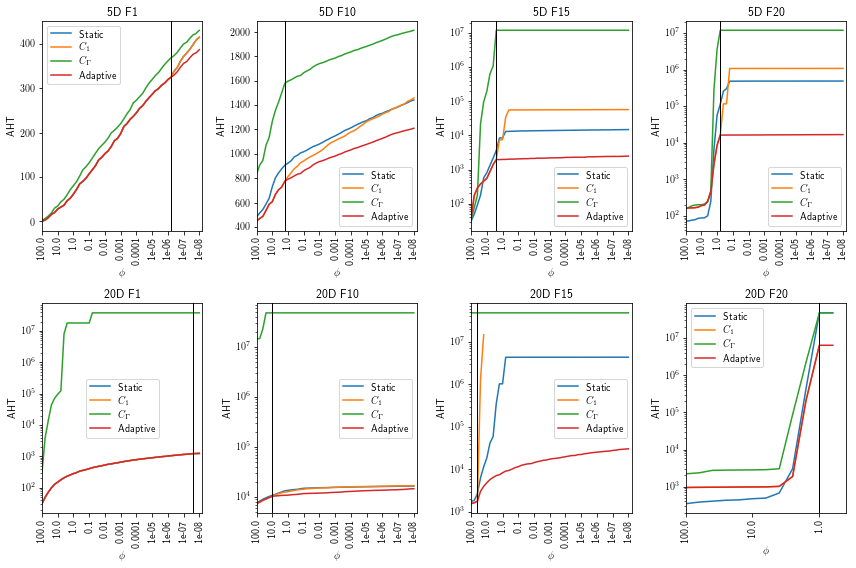

In [40]:
def plotCompoundOnAxis(df, row, ax, *, title='', log=False):
    for column in ['Static index', '$C_1$ index', '$C_{\\Gamma}$ index']:
        orig_idx = int(row.loc[column])
        ax.plot(df.iloc[orig_idx][columns].values, '-', label=column[:-6])

    split_idx = columns.index(row.loc['split'])
    idx1 = row.loc['$C_1$ index']
    part1 = df.iloc[idx1][columns[:split_idx+1]].values

    idx2 = row.loc[r"$C_{\Gamma}$ index"]
    part2 = df.iloc[idx2][columns[split_idx:]].values
    part2 = (part2 - part2[0]) + df.iloc[idx1][columns[split_idx]]
    compound = np.concatenate((part1, part2[1:]))
    ax.plot(compound, '-', label='Adaptive')

    num_valids = len(compound[~np.isnan(compound.astype(np.float))])
    
    ax.axvline(split_idx, linewidth=1, color='black')

    ax.set_ylabel("AHT")
    ax.set_xlabel(r"$\phi$")
    ax.set_xticks(np.arange(len(target_values))[::5])
    ax.set_xticklabels(target_values[::5])
    ax.set_xlim([0, num_valids])
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(title)
    ax.legend(loc=0)
    if log:
        ax.set_yscale('log')
    
    

def plotCompounds(overview, data, cases, fig, *, log=defaultdict(lambda: False), save_name=None):    
    
    for idx, row in overview.iterrows():

        exp, ax = cases[idx]
        ndim, fid = exp
        title = '{ndim}D F{fid}'.format(ndim=ndim, fid=fid)
        df = data[(ndim, fid)]

        plotCompoundOnAxis(df, row, ax, title=title, log=log[(ndim, fid)])

    fig.tight_layout()
    if save_name:
        fig.savefig(save_name+'.pdf')
        fig.savefig(save_name+'.png')

log = defaultdict(lambda: True, {(5, 1): False, (5, 10): False})
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(12,8))
cases = list(zip(product(ndims, fids), axes.flatten()))

plotCompounds(split_overview, full_data, cases, fig, log=log, save_name='interpolated_ERT_splits')
fig.show()

The results for 5D F1 and F10 are the clearest and most promising. Especially 5D F10 shows how `part 2` has a clear knee-point that is optimally identified and suggests a potential improvement of over 16%.

On the other hand, the results for 20D F20 seem not very informative as most target values are not reached.

The remaining functions are dominated by ERT scores that are near the maximum, i.e., only a few runs succeeded up to the point where the split is identified. After that, the behavior is no longer determined by the `max_budget` penalty for every failed run, but only the behavior of those runs that did succeed is taken into account in determining these results. This makes the approach a greedy one, that is fine with taking the risk that several runs will not succeed, simply because after a while, it can ignore the penalty given for that. Note that this is an inherent problem of aggregating in any way over a set of runs which did not all reach the desired target value, regardless of whether it is measured by ERT or bootstrapped aRT.

An alternative explanation might be that these are configurations that require a lot of time to learn internal parameters before 'getting in the flow' that allows them to make progress in the optimization task. (B)IPOP with its adaptive population size is an example of a module that could exhibit such behavior. If that is the case, it would be interesting to examine the parameter values when the knee-point occurs. At the same time, it would have to be taken into account when implementing this in an actual adaptive configuration setting.

## Leaving out (B)IPOP variants

To examine the potential influence of the second possible explanation in the previous section, we now repeat the experiment with all (B)IPOP variants excluded from the dataset.

In [41]:
def filterbipop(df):
    df = df.assign(bipop=df['Representation'].astype(str).str[28] != '0')
    df = df[df['bipop'] == False]
    df = df.drop(columns=['bipop'])
    return df.reset_index(drop=True)

filtered_data = {(ndim, fid): filterbipop(full_data[(ndim, fid)]) for ndim, fid in product(ndims, fids)}

In [42]:
filtered_split_overview = calculatesplitbasedoverview(filtered_data, product(ndims, fids))
displayoverview(filtered_split_overview, filtered_data)

,ndim,fid,Static,Adaptive,relative improvement,split,Static rep,$C_1$ rep,$C_{\Gamma}$ rep
0,5,1,4.224500e+02,3.881500e+02,0.081193,10e-0.4,"[0,0,1,1,0,0,1,0,0,0,0]","[1,0,1,1,0,1,1,1,0,0,1]","[0,0,1,1,0,0,1,0,0,0,0]"
1,5,10,1.747760e+03,1.384520e+03,0.207832,10e0.0,"[0,1,1,1,0,1,1,0,0,0,2]","[1,0,0,1,0,1,1,0,0,0,2]","[0,1,1,1,1,0,0,0,0,0,1]"
2,5,15,1.499940e+04,2.584280e+03,0.827708,10e0.4,"[0,0,1,1,1,0,1,0,0,0,1]","[0,0,1,1,0,0,0,0,0,0,1]","[0,1,0,0,1,0,1,0,1,0,0]"
3,5,20,1.078910e+06,3.736817e+04,0.965365,10e-0.2,"[0,1,0,1,0,1,0,1,0,0,1]","[0,0,1,1,0,0,0,1,0,0,1]","[1,0,1,1,0,1,0,0,0,0,0]"
4,20,1,1.440000e+03,1.365200e+03,0.051944,10e1.2,"[1,0,1,1,0,0,1,0,0,0,2]","[1,0,1,1,0,1,1,0,0,0,2]","[1,0,1,1,0,0,1,0,0,0,2]"
5,20,10,1.756448e+04,1.575504e+04,0.103017,10e0.8,"[0,0,1,1,1,0,0,0,0,0,0]","[0,0,0,1,1,0,0,0,0,0,1]","[1,0,0,0,0,1,1,1,0,0,2]"
6,20,15,6.457789e+06,8.671292e+05,0.865724,10e0.4,"[0,0,1,1,1,0,1,0,0,0,1]","[0,0,1,0,1,0,0,0,0,0,1]","[0,1,0,0,1,0,0,0,0,0,1]"
7,20,20,4.804820e+07,6.485636e+06,0.865018,10e0.0,"[1,1,1,1,1,1,0,1,0,0,1]","[0,0,1,1,1,0,0,1,0,0,1]","[1,1,1,1,1,1,0,1,0,0,1]"


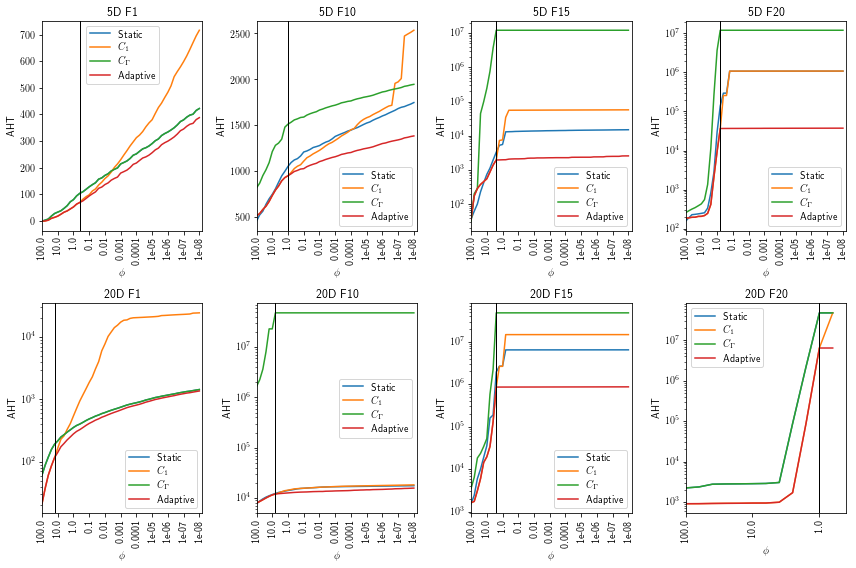

In [43]:
log = defaultdict(lambda: True, {(5, 1): False, (5, 10): False})
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(12,8))
cases = list(zip(product(ndims, fids), axes.flatten()))

plotCompounds(filtered_split_overview, filtered_data, cases, fig, log=log, save_name='no-bipop_interpolated_ERT_splits')

Overall, the results seem the same: Only 5D F1 and F10 can really be plotted without having to resort to a log-scale. The most noticable thing is that the best 'regular' results are now worse than before, as the succesful (B)IPOP module is no longer allowed in the configurations.

# Only fully successful

As we're still dealing with the fitness 'jumps' caused by the ERT calculation, we'll now look only at those configurations which were 100% successful. This does mean we will reach fewer targets, but those results will not be distorted and are therefore more reliable.

Note: (for now) this is only a one-time filter based on the smallest convergence target. Especially for the single-split variant, it may still be interesting to perform this filter for every possible 'part1' by itself.

In [44]:
file_name = 'interpolated_ART_data_{ndim}D-f{fid}.csv'

raw_data = {(ndim, fid): get_data(ndim=ndim, fid=fid) for ndim, fid in product(ndims, fids)}

In [45]:
def aggregateByFilteredERT(df, max_budget):
    df = df.drop(columns=['instance ID', 'repetition'])

    sums = df.fillna(max_budget).groupby(by=['Representation', 'ndim', 'function ID']).sum()
    counts = df.groupby(by=['Representation', 'ndim', 'function ID']).count()
    
    # Count how many runs should be successful and discard anything below that value
    max_successful = counts.max()[0]
    counts[counts != max_successful] = np.NaN
    
    ERTs = sums/counts
    ERTs = ERTs.replace(np.inf, np.NaN).reset_index()
    return ERTs

In [46]:
# Some caching again
successful_only_data = {(ndim, fid): aggregateByFilteredERT(raw_data[(ndim, fid)], max_budget=ndim*10e4) for ndim, fid in product(ndims, fids)}

In [47]:
calcresults(successful_only_data)

,ndim,fid,Target,Empirical best,Adaptive best,Relative improvement
0,5,1,10e-8.0,412.00,218.05,0.470752
1,5,10,10e-8.0,1437.08,832.00,0.421048
2,5,15,10e-8.0,14812.72,9220.80,0.377508
3,5,20,10e-0.2,14535.16,10951.92,0.246522
4,20,1,10e-8.0,1269.05,1058.45,0.165951
5,20,10,10e-8.0,16565.48,11135.00,0.327819
6,20,15,10e0.6,45279.08,26249.16,0.420281
7,20,20,10e0.2,14476.76,12829.40,0.113793


In [48]:
successful_split_overview = calculatesplitbasedoverview(successful_only_data, product(ndims, fids))
displayoverview(successful_split_overview, successful_only_data)

,ndim,fid,Static,Adaptive,relative improvement,split,Static rep,$C_1$ rep,$C_{\Gamma}$ rep
0,5,1,412.00,383.70,0.068689,10e-2.2,"[0,0,1,1,0,0,1,1,0,1,0]","[1,0,1,1,0,1,1,1,0,2,0]","[0,0,1,1,0,0,1,1,0,1,1]"
1,5,10,1437.08,1207.12,0.160019,10e0.2,"[1,1,0,0,0,1,1,0,0,2,2]","[0,1,0,0,1,1,1,0,1,2,0]","[0,1,1,0,1,0,0,0,0,1,2]"
2,5,15,14812.72,11524.24,0.222004,10e0.4,"[0,0,1,1,0,0,1,1,0,1,1]","[0,0,1,1,0,0,0,0,0,0,1]","[0,0,0,0,1,0,1,1,0,1,1]"
3,5,20,14535.16,11628.36,0.199984,10e0.0,"[0,1,0,1,0,1,0,1,0,2,2]","[0,1,1,1,0,0,1,1,0,1,1]","[0,0,1,0,0,0,0,1,0,2,1]"
4,20,1,1269.05,1231.40,0.029668,10e-3.8,"[0,0,1,1,0,1,1,0,0,2,1]","[0,0,1,1,0,1,1,0,0,2,2]","[0,0,1,1,0,1,1,0,0,2,1]"
5,20,10,16565.48,15003.72,0.094278,10e1.8,"[0,0,0,0,1,0,0,0,0,1,0]","[0,0,0,1,1,0,0,0,0,1,1]","[0,0,0,0,1,1,0,1,0,1,1]"
6,20,15,45279.08,42020.80,0.071960,10e0.8,"[0,0,1,1,1,0,0,0,0,0,1]","[0,0,1,1,1,0,0,0,0,0,1]","[0,0,1,0,1,0,0,0,0,1,1]"
7,20,20,14476.76,12942.96,0.105949,10e0.4,"[0,0,0,1,0,0,0,1,0,2,2]","[1,1,1,0,0,1,1,1,0,0,1]","[0,0,0,1,0,0,0,1,0,2,2]"


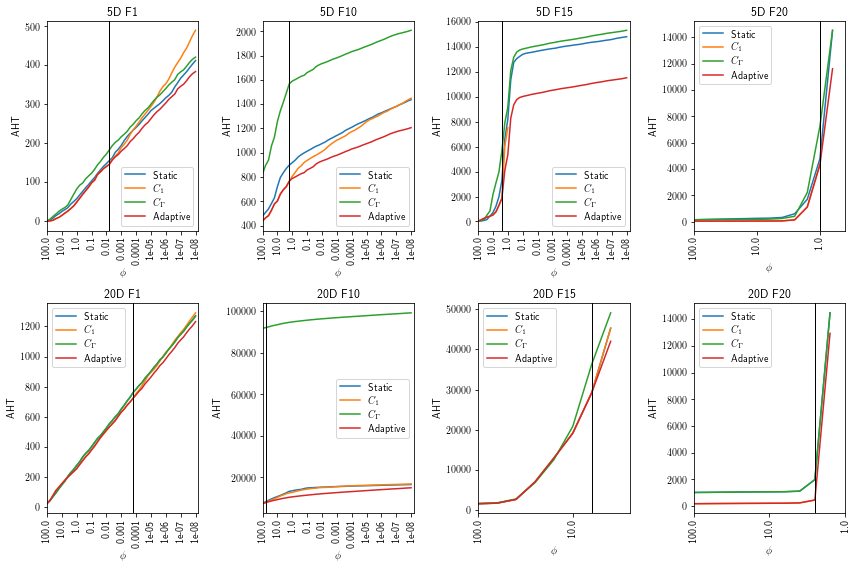

In [49]:
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(12,8))
cases = list(zip(product(ndims, fids), axes.flatten()))

plotCompounds(successful_split_overview, successful_only_data, cases, fig,
              save_name='successful_only_interpolated_ERT_splits')

/scratch/python/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


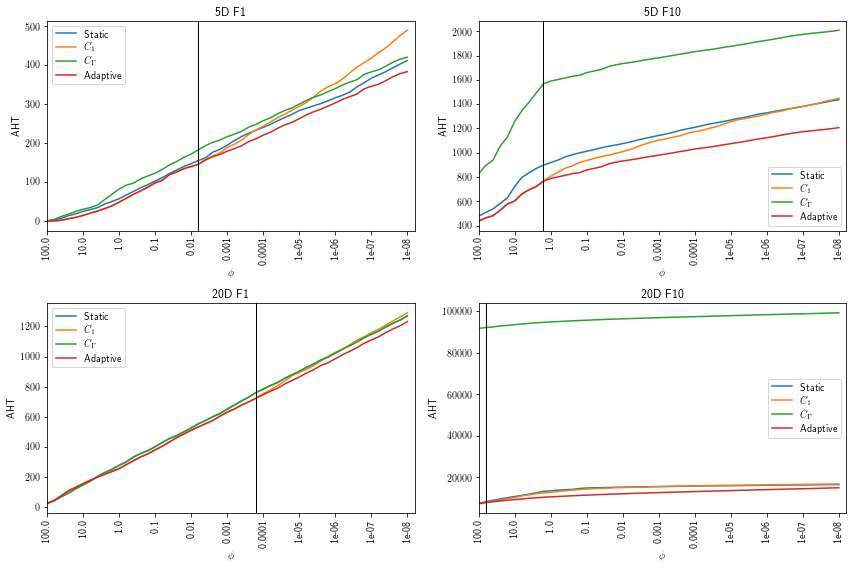

In [50]:
experiments = product(ndims, fids[:2])
selection = successful_split_overview.iloc[[0,1,4,5]].reset_index()

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,8))
cases = list(zip(experiments, axes.flatten()))

plotCompounds(selection, successful_only_data, cases, fig, 
              save_name='successful_only_interpolated_ERT_splits_p1')

fig.show()

/scratch/python/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


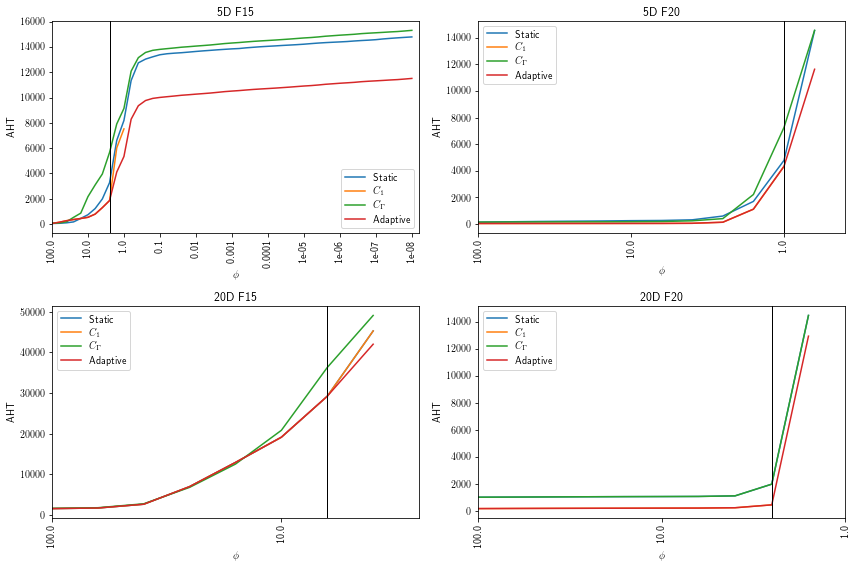

In [51]:
experiments = product(ndims, fids[2:])
selection = successful_split_overview.iloc[[2,3,6,7]].reset_index()

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,8))
cases = list(zip(experiments, axes.flatten()))

plotCompounds(selection, successful_only_data, cases, fig, 
              save_name='successful_only_interpolated_ERT_splits_p2')

fig.show()